# Lab 02: Credit Ratings

---
author: Yiran Hu
date: February 12, 2024
embed-resources: true
---

## Introduction

In this lab, I aim to predict credit ratings using bank customers' income and demographic information, such as age, education level, gender, student status, marital status, and ethnicity. This endeavor seeks to reduce reliance on external credit rating agencies, offering a cost-saving measure for small banks and credit unions. Utilizing data from the textbook "An Introduction to Statistical Learning", we will apply machine learning techniques to develop a K-Nearest-Neighbor regression model that accurately forecasts an individual's credit score. This lab represents a practical application of statistical learning principles to address real-world financial challenges.

## Methods

In [30]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from joblib import dump

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt

### Data

In [7]:
credit_train = pd.read_csv("https://cs307.org/lab-02/data/credit-train.csv")
# create X and y for train
X_train = credit_train.drop("Rating", axis=1)  # delete the rating column
y_train = credit_train["Rating"]

The Credit Ratings dataset originates from the textbook "An Introduction to Statistical Learning." The modified Credit Ratings dataset for CS 307 Lab 02 includes data for predicting individual consumer credit scores, featuring attributes such as income, age, education, gender, student status, marital status, and ethnicity.

In [8]:
credit_train

,Rating,Income,Age,Education,Gender,Student,Married,Ethnicity
0,448.0,49.570,28.0,9.0,Female,No,Yes,Asian
1,411.0,26.813,55.0,16.0,Female,No,No,Caucasian
2,181.0,30.406,79.0,14.0,Male,No,Yes,African American
3,169.0,27.349,51.0,16.0,Female,No,Yes,African American
4,292.0,12.068,44.0,18.0,Female,No,Yes,Asian
...,...,...,...,...,...,...,...,...
295,369.0,40.442,81.0,8.0,Female,No,No,African American
296,272.0,NaN,69.0,8.0,Male,No,Yes,Caucasian
297,251.0,14.132,75.0,17.0,Male,No,No,Caucasian
298,747.0,135.118,81.0,15.0,Female,No,Yes,Asian


#### Summary Statistics

In [26]:
# Rating (Target) Statistics
mean_rating = y_train.mean()
std_rating = y_train.std()
print("Rating Mean: ", mean_rating, "\nRating Standard Deviation: ", std_rating)

Rating Mean:  357.51666666666665 
Rating Standard Deviation:  157.09976929943386


In [27]:
# Rating Statistics Based on Student Status
credit_notstudent = credit_train[credit_train["Student"] == "No"]
credit_student = credit_train[credit_train["Student"] == "Yes"]
mean_notstudent = credit_notstudent["Rating"].mean()
std_notstudent = credit_notstudent["Rating"].std()
mean_student = credit_student["Rating"].mean()
std_student = credit_student["Rating"].std()
print("Count for not student: ", len(credit_notstudent), "\nRating Mean for Not Student: ",
      mean_notstudent, "\nRating Standard Deviation for Not Student: ", std_notstudent)
print("\nCount for student: ", len(credit_student), "\nRating Mean for Student: ",
      mean_student, "\nRating Standard Deviation for Student: ", std_student)

Count for not student:  266 
Rating Mean for Not Student:  359.24436090225566 
Rating Standard Deviation for Not Student:  158.38314085692082

Count for student:  30 
Rating Mean for Student:  344.1 
Rating Standard Deviation for Student:  146.64626686761207


In [11]:
# Rating Statistics Based on Marriage Status
credit_single = credit_train[credit_train["Married"] == "No"]
credit_married = credit_train[credit_train["Married"] == "Yes"]
mean_single = credit_single["Rating"].mean()
std_single = credit_single["Rating"].std()
mean_married = credit_married["Rating"].mean()
std_married = credit_married["Rating"].std()
print("Count for single: ", len(credit_single), "\nRating Mean for Single: ", mean_single, "\nRating Standard Deviation for Single: ", std_single)
print("\nCount for married: ", len(credit_married), "\nRating Mean for Married: ", mean_married, "\nRating Standard Deviation for Married: ", std_married)

Count for single:  118 
Rating Mean for Single:  359.3898305084746 
Rating Standard Deviation for Single:  154.6773887695038

Count for married:  178 
Rating Mean for Married:  358.2752808988764 
Rating Standard Deviation for Married:  159.8516528251666


In [12]:
# Correlation with Age and Income
print("age correlation: ", credit_train["Rating"].corr(credit_train["Age"]))
print("income correlation: ",
      credit_train["Rating"].corr(credit_train["Income"]))

age correlation:  0.14869459512179506
income correlation:  0.7955279488315458


In [13]:
# Missing Proportion
missing_proportion = credit_train.isnull().mean()
print(missing_proportion)

Rating       0.000000
Income       0.146667
Age          0.096667
Education    0.070000
Gender       0.016667
Student      0.013333
Married      0.013333
Ethnicity    0.063333
dtype: float64


#### Visualizations

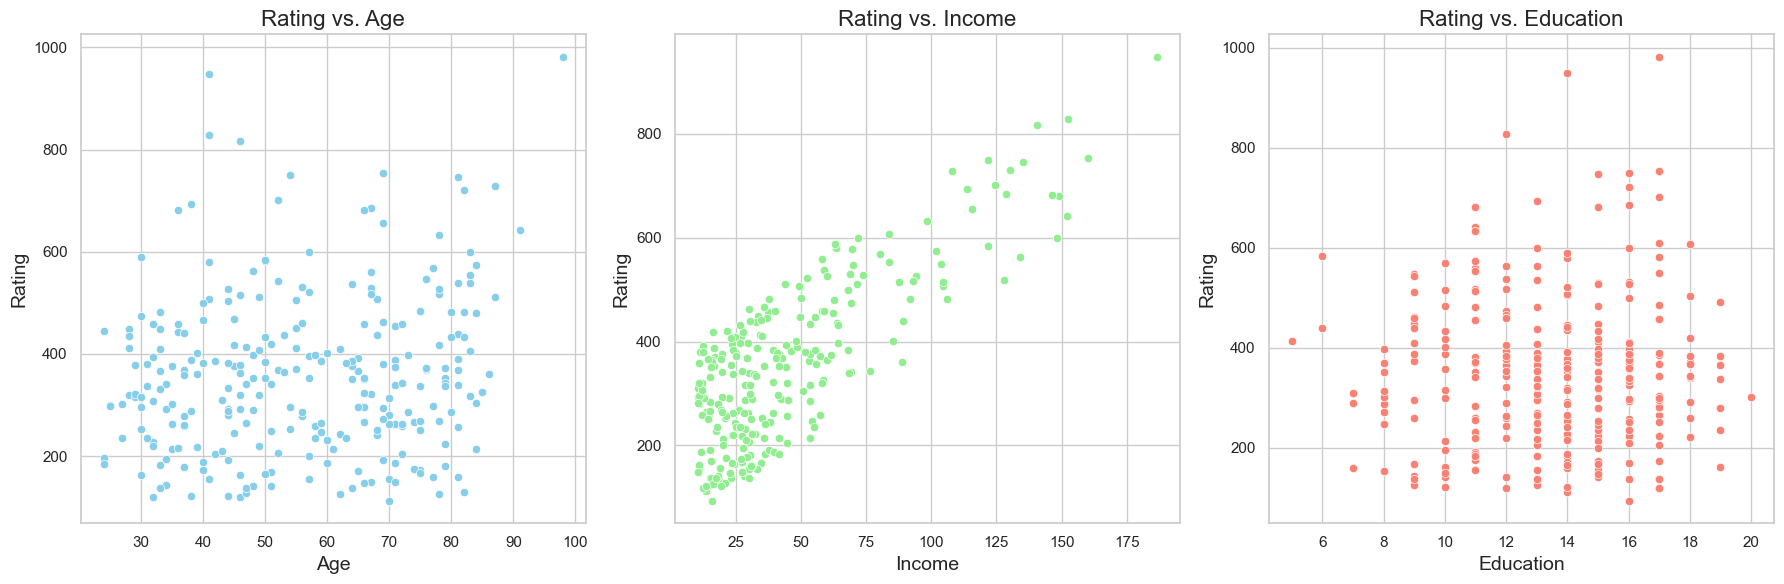

In [43]:
sns.set_theme(style="whitegrid", palette="pastel")

# create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Rating and Age
sns.scatterplot(ax=axes[0], x='Age', y='Rating',
                data=credit_train, color="skyblue")
axes[0].set_title('Rating vs. Age', fontsize=16)
axes[0].set_xlabel('Age', fontsize=14)
axes[0].set_ylabel('Rating', fontsize=14)

# Rating and Income
sns.scatterplot(ax=axes[1], x='Income', y='Rating',
                data=credit_train, color="lightgreen")
axes[1].set_title('Rating vs. Income', fontsize=16)
axes[1].set_xlabel('Income', fontsize=14)
axes[1].set_ylabel('Rating', fontsize=14)

# Rating and Education
sns.scatterplot(ax=axes[2], x='Education', y='Rating',
                data=credit_train, color="salmon")
axes[2].set_title('Rating vs. Education', fontsize=16)
axes[2].set_xlabel('Education', fontsize=14)
axes[2].set_ylabel('Rating', fontsize=14)

plt.tight_layout()
plt.show()

Based on the summary statistics, it was discovered that there is a relatively high correlation between Rating and Income, but not much association between Rating and Age. Therefore, I created three scatter plots to visually compare the relationships between three numeric features and Rating. From these plots, it is evident that Income plays a significant role in predicting Rating, while Age and Education do not help much in predicting Rating.

### Models

In [15]:
# find data types of X_train(7 features in total)
X_train.dtypes

Income       float64
Age          float64
Education    float64
Gender        object
Student       object
Married       object
Ethnicity     object
dtype: object

In [16]:
# split the data into numerical and categorical
numeric_features = X_train.select_dtypes(include=["float64"]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns

In this project, I processed a dataset with seven features, comprising both numerical and categorical data. I applied one-hot encoding to transform categorical variables into a binary format, making them suitable for use in the model. For numerical features, I used imputation to handle missing values and standardization to normalize their scales.

In [17]:
# define how to handle missing data and scale features for numeric and categorical features
numeric_transformer = Pipeline(
    steps=[
        ("Iterative Imputer", IterativeImputer(max_iter=10, random_state=0)),
        ("Standardization", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("Modal Imputer", SimpleImputer(strategy="most_frequent")),
        ("One-Hot Encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

In [18]:
# create general preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("Numeric Transformer", numeric_transformer, numeric_features),
        ("Categorical Transformer", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)

I chose the K-Nearest Neighbors (KNN) model for prediction, due to its effectiveness in handling complex patterns. To optimize the model, I conducted hyperparameter tuning through grid search, focusing on the number of neighbors, weight strategies, and distance metrics.

In [19]:
# Create the pipeline
model_pipeline = Pipeline(steps=[
    ("Preprocessor", preprocessor),
    ("Regressor", KNeighborsRegressor())
])

In [20]:
# define the parameter grid for grid search
param_grid = {
    "Regressor__n_neighbors": range(1, 20),  # set the range of k from 1 to 19
    # define how the neighbors contribute, equally or have different weights based on distance
    "Regressor__weights": ["uniform", "distance"],
    # distance metrics to be used for calculating the proximity between data points
    "Regressor__metric": ["euclidean", "manhattan", "chebyshev"]
}

In [21]:
# setup grid search with cross-validation
grid_search = GridSearchCV(model_pipeline, param_grid, cv=230, scoring="neg_mean_squared_error")

In [22]:
# fit models
grid_search.fit(X_train, y_train)

GridSearchCV(cv=230,
             estimator=Pipeline(steps=[('Preprocessor',
                                        ColumnTransformer(transformers=[('Numeric '
                                                                         'Transformer',
                                                                         Pipeline(steps=[('Iterative '
                                                                                          'Imputer',
                                                                                          IterativeImputer(random_state=0)),
                                                                                         ('Standardization',
                                                                                          StandardScaler())]),
                                                                         Index(['Income', 'Age', 'Education'], dtype='object')),
                                                                        ('Categorical '
                                                                         'Transformer',
                                                                         Pipeline(steps=[('Modal '
                                                                                          'Imputer',
                                                                                          SimpleI...
                                                                                         ('One-Hot '
                                                                                          'Encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Gender', 'Student', 'Married', 'Ethnicity'], dtype='object'))])),
                                       ('Regressor', KNeighborsRegressor())]),
             param_grid={'Regressor__metric': ['euclidean', 'manhattan',
                                               'chebyshev'],
                         'Regressor__n_neighbors': range(1, 20),
                         'Regressor__weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [24]:
# save models
dump(grid_search, "credit-ratings.joblib")

['credit-ratings.joblib']

## Results

In [44]:
print("Best parameters found:", grid_search.best_params_)
print("Lowest RMSE found:", np.sqrt(-grid_search.best_score_))

Best parameters found: {'Regressor__metric': 'chebyshev', 'Regressor__n_neighbors': 13, 'Regressor__weights': 'uniform'}
Lowest RMSE found: 107.11345806857459


To ensure the model's robustness, I changed cross-validation (CV) to evaluate its performance on unseen data, ultimately selecting a configuration (cv=230, use "chebyshev" method to calculate distances, each neighbor has equal weight, and choose k=13) that demonstrated strong predictive accuracy. This approach allowed us to develop a reliable model for predicting credit ratings based on a mix of income and demographic information.

## Discussion

### Conclusion